In [1]:
import torchvision.models.detection as torch_detect
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

from tqdm.auto import tqdm
from os.path import splitext

from utils.dataset_detection import EgoHandDataset
from utils.utils import plot_losses

In [ ]:
LOAD_ON = False
TRAIN_ON = False

In [2]:
import requests
import zipfile

if LOAD_ON:
    url = 'http://vision.soic.indiana.edu/egohands_files/egohands_data.zip'
    filename = 'egohands_data.zip'

    response = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        f.write(response.content)

    print(f'{filename} downloaded!')

    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('EgoHand_dataset')

    print("File unzipped successfully!")

In [3]:
IMAGE_DIR = 'EgoHand_dataset/_LABELLED_SAMPLES'
ANNO_PATH = 'EgoHand_dataset/metadata.mat'
MODEL_PATH = 'detection/m_keypoints.pth'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

BATCH_SIZE = 1
EPOCH_NUM = 10
TRAIN_RATIO = 0.8
NUM_CLASSES = 2

cuda


In [4]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [30]:
model = torch_detect.fasterrcnn_resnet50_fpn(weights=torch_detect.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torch_detect.faster_rcnn.FastRCNNPredictor(in_features, NUM_CLASSES)
for param in model.backbone.parameters():
    param.requires_grad = False

model = model.to(DEVICE)

dataset = EgoHandDataset(IMAGE_DIR, ANNO_PATH, transform=transforms.Compose([
    transforms.ToTensor(),
]))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, drop_last=True,  
                        collate_fn=collate_fn)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, drop_last=True, 
                        collate_fn=collate_fn)

if TRAIN_ON:
    model.train()

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, 
        lr=0.0001,         # Lower learning rate for fine-tuning
        momentum=0.9,      # Common momentum value
        weight_decay=0.0005  # Regularization term)
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1)

    tr_losses, val_losses = [], []

    for epoch in range(EPOCH_NUM):
        epoch_loss = 0
        prog_bar_train = tqdm(train_loader, total=2000)

        for i, batch in enumerate(prog_bar_train):
            if i >= 2000:
                break
            images, targets = batch

            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()
            prog_bar_train.set_description(desc=f"Loss: {losses.item():.4f}")

        val_loss = 0
        prog_bar_val = tqdm(val_loader, total=300)

        with torch.no_grad():
            for i, batch in enumerate(prog_bar_val):
                if i >= 300:
                    break
                images, targets = batch

                images = list(image.to(DEVICE) for image in images)
                targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

                val_loss += losses.item()
                prog_bar_val.set_description(desc=f"ValLoss: {losses.item():.4f}")

        train_loss = epoch_loss / 2000
        val_loss = val_loss / 300
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        tr_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(train_loss)

        torch.save(model.state_dict(), splitext(MODEL_PATH)[0] + '_' + str(epoch+1) + '.pth')

    torch.save(model.state_dict(), MODEL_PATH)
    plot_losses(tr_losses, val_losses, 'Detection_Losses.png')

SyntaxError: expected ':' (1409923191.py, line 10)

In [22]:
model.eval()
predictions = []
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        if i >= 15:
            break
        images, targets = batch

        images = list(image.to(DEVICE) for image in images)
        prediction = model(images)
        prediction[0]['image'] = images[0].cpu()
        predictions.append(prediction[0])

In [23]:
print(predictions[0])

{'boxes': tensor([[605.1708, 566.4645, 912.2368, 718.4613],
        [616.1860, 335.0903, 783.2831, 451.8370],
        [467.9053, 310.3860, 608.5151, 439.3929],
        [488.7441, 328.1684, 693.8975, 438.7563],
        [443.0117, 292.6556, 588.3934, 384.4603],
        [520.0331, 296.5249, 786.9704, 438.4781],
        [459.6881, 353.8264, 587.0458, 432.2747],
        [  7.2726, 380.5949,  61.8948, 525.7180],
        [437.6943, 701.6790, 624.3259, 719.0325],
        [667.8572, 312.8355, 823.6891, 449.5162],
        [380.8370,   5.7599, 951.7281, 410.2263]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.9958, 0.9574, 0.8786, 0.5929, 0.3364, 0.2381, 0.0763, 0.0692,
        0.0615, 0.0508], device='cuda:0'), 'image': tensor([[[0.5569, 0.5608, 0.5608,  ..., 0.0000, 0.0000, 0.0039],
         [0.5098, 0.5333, 0.5608,  ..., 0.0000, 0.0000, 0.0000],
         [0.6078, 0.5843, 0.5216,  ..., 0.0000, 0.0000, 0.0000],
         ...,


In [28]:
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.patches as patches

def plot_results(predictions, filename):
    num_images = len(predictions)
    _, axes = plt.subplots(math.ceil(num_images / 5), 5, figsize=(15, 10))
    axes = list(axes)
    for i, prediction in enumerate(predictions):
        image = np.array(prediction['image'])
        image = image.transpose((1, 2, 0))

        boxes, scores = prediction['boxes'], prediction['scores']
        boxes = boxes[scores > 0.8]

        axes[i // 5][i % 5].imshow(image)
        for box in boxes:  
            x1, y1, x2, y2 = box.cpu().numpy()
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
            axes[i // 5][i % 5].add_patch(rect)
        axes[i // 5][i % 5].axis('off')
    plt.tight_layout()
    plt.savefig('figures/' + filename)

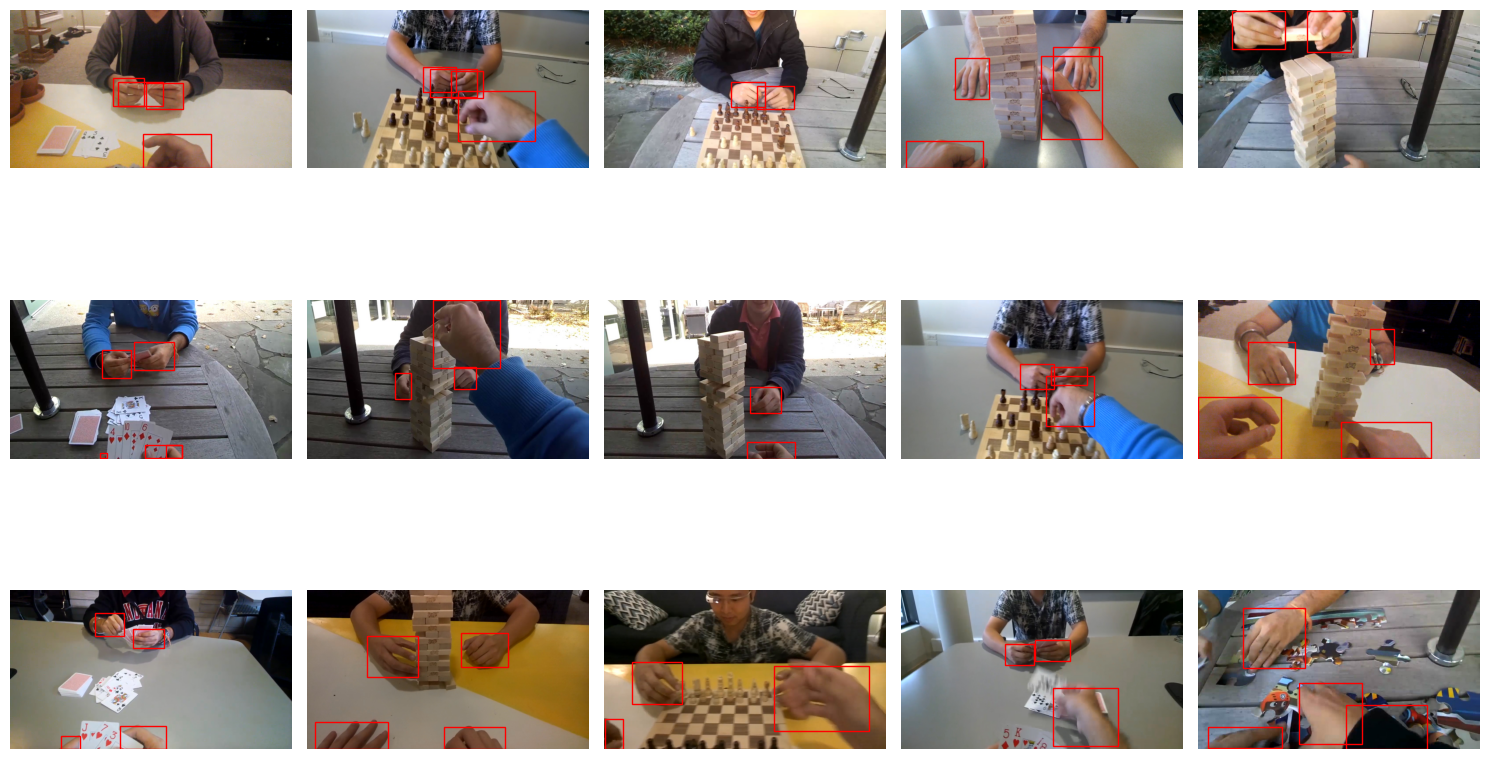

In [29]:
plot_results(predictions, 'Detection_Results.png')